In [1]:
import numpy as np #Import relevant packages
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import glob
import csv
import matplotlib.pyplot as plt

In [2]:
def unpack_data(filepath): #Returns a dictionary where each item is a df containing one run. One dict per generation.
    all_files = glob.glob(filepath + "/*.csv")
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[77:-4])
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
    for k, v in datadict.items():
        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
    return datadict

def format_data(datadict, window): #Turn dictionaries of data into features and samples lists
    x_data = []
    y_data = []
    for k, v in datadict.items():
        for i in range(len(v)):
            if i >= window:
                y_data.append(v.iloc[i]["trading_price"])
                xi = v.iloc[i-window:i].to_numpy()
                x_data.append(xi)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    y_data = np.reshape(y_data, (y_data.shape[0], 1))
    return x_data, y_data

def normalise_data(xarray, yarray): #Take the natural log and then normalise prices
    yarray_log = np.log(yarray)
    xarray_log = np.log(xarray)
    xsc = StandardScaler()
    instances, timesteps, features = xarray_log.shape
    xarray_log = np.reshape(xarray_log, (-1, features))
    xarray_norm = xsc.fit_transform(xarray_log)
    xarray_norm = np.reshape(xarray_norm, (instances, timesteps, features))
    ysc = StandardScaler().fit(yarray_log)
    yarray_norm = ysc.transform(yarray_log)
    return xarray_norm, yarray_norm, xsc, ysc

def split_data(xarray, yarray, trainratio): #Split the data into training and test sets
    train_len = int(len(xarray)*trainratio)
    test_len = len(xarray) - train_len
    x_train, y_train, x_test, y_test = xarray[:train_len], yarray[:train_len], xarray[train_len:], yarray[train_len:]
    return x_train, y_train, x_test, y_test

In [3]:
gen3 = unpack_data("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen3_sims/data")

In [5]:
X4, y4 = format_data(gen3, 20)
print(X4.shape)
print(y4.shape)

(30282, 20, 2)
(30282, 1)


In [6]:
X4_train, y4_train, X4_test, y4_test = split_data(X4, y4, 0.8)

In [7]:
X4_train, y4_train, X4scale, y4scale = normalise_data(X4_train, y4_train)
X4_test, y4_test, _, _ = normalise_data(X4_test, y4_test)

In [9]:
print(X4scale.mean_)
print(X4scale.var_)
print(y4scale.mean_)
print(y4scale.var_)
print(X4_train)
print(y4_train)

[4.67667505 4.79155419]
[0.07729432 0.0161154 ]
[4.67906749]
[0.08509756]
[[[-0.25719457 -1.46820968]
  [-0.23067564 -1.43048892]
  [-0.20825178 -1.4257865 ]
  ...
  [-0.13623797 -1.26524845]
  [-0.13102484 -1.25757522]
  [-0.13971759 -1.24990946]]

 [[-0.23067564 -1.43048892]
  [-0.20825178 -1.4257865 ]
  [-0.22496744 -1.41795536]
  ...
  [-0.13102484 -1.25757522]
  [-0.13971759 -1.24990946]
  [-0.11716    -1.24225115]]

 [[-0.20825178 -1.4257865 ]
  [-0.22496744 -1.41795536]
  [-0.19196666 -1.37580124]
  ...
  [-0.13971759 -1.24990946]
  [-0.11716    -1.24225115]
  [-0.14145866 -1.23460027]]

 ...

 [[-0.17399719 -1.32690486]
  [-0.2075422  -1.32767863]
  [-0.1708354  -1.32381055]
  ...
  [-0.12131385 -1.21855759]
  [-0.14285213 -1.21092968]
  [-0.10955706 -1.20330916]]

 [[-0.2075422  -1.32767863]
  [-0.1708354  -1.32381055]
  [-0.20470526 -1.31376243]
  ...
  [-0.14285213 -1.21092968]
  [-0.10955706 -1.20330916]
  [-0.13102484 -1.18809019]]

 [[-0.1708354  -1.32381055]
  [-0.204705

In [10]:
lstm4=keras.Sequential() #Set up the architecture of the model

lstm4.add(layers.LSTM(units=16, input_shape=(X4_train.shape[1], X4_train.shape[2])))
lstm4.add(layers.Dropout(0.2))

lstm4.add(layers.Dense(units=1))

In [12]:
print(lstm4.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1216      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
lstm4.compile(optimizer='nadam', loss='mean_squared_error') #Compile and train the model

history4 = lstm4.fit(X4_train, y4_train, epochs = 10, batch_size = 32, validation_split=0.2, shuffle=False)

Train on 19380 samples, validate on 4845 samples
Epoch 1/10
19380/19380 [==============================] - 36s 2ms/sample - loss: 0.1576 - val_loss: 0.0172
Epoch 2/10
19380/19380 [==============================] - 23s 1ms/sample - loss: 0.0350 - val_loss: 0.0072
Epoch 3/10
19380/19380 [==============================] - 26s 1ms/sample - loss: 0.0254 - val_loss: 0.0045
Epoch 4/10
19380/19380 [==============================] - 24s 1ms/sample - loss: 0.0227 - val_loss: 0.0036
Epoch 5/10
19380/19380 [==============================] - 25s 1ms/sample - loss: 0.0212 - val_loss: 0.0067
Epoch 6/10
19380/19380 [==============================] - 26s 1ms/sample - loss: 0.0205 - val_loss: 0.0047
Epoch 7/10
19380/19380 [==============================] - 23s 1ms/sample - loss: 0.0203 - val_loss: 0.0095
Epoch 8/10
19380/19380 [==============================] - 23s 1ms/sample - loss: 0.0203 - val_loss: 0.0018
Epoch 9/10
19380/19380 [==============================] - 24s 1ms/sample - loss: 0.0198 - val_l

In [14]:
lstm4.save("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm4")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm4/assets


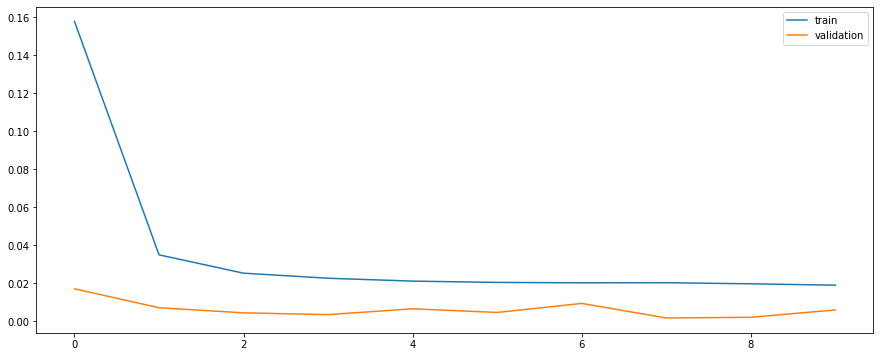

In [15]:
plt.figure(figsize=(15,6))
plt.plot(history4.history["loss"], label="train")
plt.plot(history4.history["val_loss"], label="validation")
plt.legend()

In [16]:
y4_pred = lstm4.predict(X4_test)
y4_train_inv = y4scale.inverse_transform(y4_train.reshape(1, -1))
y4_test_inv = y4scale.inverse_transform(y4_test.reshape(1, -1))
y4_pred_inv  = y4scale.inverse_transform(y4_pred)

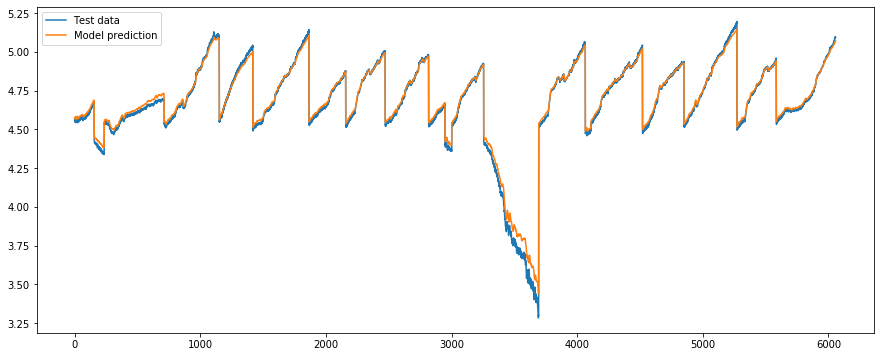

In [17]:
plt.figure(figsize=(15,6))
plt.plot(y4_test_inv.flatten(), label="Test data")
plt.plot(y4_pred_inv.flatten(), label="Model prediction")
plt.legend()